# Cube analysis with Gammapy (part 1)

## Introduction 

In order to run a cube likelihood analysis (spectral+morphology), you first have to compute a few things by stacking data from observation runs:
* counts, background and exposure cube
* mean PSF
* mean RMF

These are the inputs to the likelihood fitting step, where you assume a parameterised gamma-ray emission model and fit it to the stacked data.

This notebook is part 1 of 2 of a tutorial how to use [gammapy.cube](http://docs.gammapy.org/en/latest/cube/index.html) to do cube analysis of IACT data. Part 1 is about these pre-computations, part 2 will be about the likelihood fitting.

We will be using the following classes:
* [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html) to load the data to stack in the cube
* [gammapy.image.SkyMask](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyMask.html) for computing the BKG model
* [gammapy.cube.SkyCube](http://docs.gammapy.org/en/latest/api/gammapy.cube.SkyCube.html) and [gammapy.cube.StackedObsCubeMaker](http://docs.gammapy.org/en/latest/api/gammapy.cube.StackedObsCubeMaker.html) to stack the data in the Cube
* [gammapy.data.ObservationList](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationList.html) to make the computation of the mean PSF and mean RMF from a set of runs.

The data used in this tutorial is 4 Crab runs from H.E.S.S..

## Setup

As always, we start with some setup for the notebook, and with imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

from gammapy.data import DataStore, ObservationList
from gammapy.image import SkyMask
from gammapy.cube import SkyCube, StackedObsCubeMaker
from gammapy.utils.energy import Energy, EnergyBounds
from gammapy.irf import TablePSF
from gammapy.background import fill_acceptance_image

## Data preparation

### 1. Define wcs specification and energy binning 

In [3]:
# define WCS specification
WCS_SPEC = {'nxpix': 50,
            'nypix': 50,
            'binsz': 0.05,
            'xref': 83.63,
            'yref': 22.01,
            'proj': 'TAN',
            'coordsys': 'CEL'}

# define reconstructed energy binning
ENERGY_SPEC = {'mode': 'edges',
               'enumbins': 5,
               'emin': 0.5,
               'emax': 40,
               'eunit': 'TeV'}

# define true energy binning
ENERGY_TRUE_SPEC = {'mode': 'edges',
                    'enumbins': 20,
                    'emin': 0.1,
                    'emax': 100,
                    'eunit': 'TeV'}

# instanciate reference cube
REF_CUBE = SkyCube.empty(**WCS_SPEC, **ENERGY_SPEC)
REF_CUBE_TRUE = SkyCube.empty(**WCS_SPEC, **ENERGY_TRUE_SPEC)

Load the data we will stack in the cube. Here we take the data from gammapy-extra with the 4 crab runs in which the hdu_table contains a link to a background model. We will define a Cube that is center on the Crab position extending to 0.5 degree around this position.

You can for example take the dataset directory we juste created with the background_model.ipynb notebook with a hdu table that has a link for each run to the background models we just created with this notebook. You just have to replace the dataset_directory by cwd+"/data".

In [4]:
# setting up the data store
data_store = DataStore.from_dir("$GAMMAPY_EXTRA/test_datasets/cube/data")

# temporary fix for load psftable for one of the run that is not implemented yet...
data_store.hdu_table.remove_row(14)

You define the Cube in which you want to stack the data: center, (x,y) pixels and energy bins

You define an exclusion mask that will be use to create the backgroud 2D map. The background map are normalized on the counts map outside the exclusion region

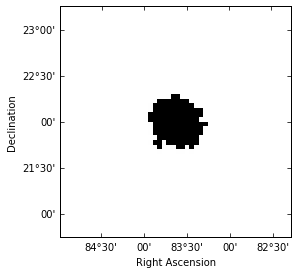

In [5]:
# read in TeVCat exclusion mask
exclusion_mask = SkyMask.read('$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits')

# reproject exclusion mask to reference cube
exclusion_mask = exclusion_mask.reproject(reference=REF_CUBE.sky_image_ref, order='nearest-neighbor')

exclusion_mask.show()

In [6]:
# write to file
exclusion_mask.write('exclusion_mask.fits.gz', overwrite=True)

Make and write the Cubes

In [7]:
#Select the offset band on which you want to select the events in the FOV of each observation
offset_band = Angle([0, 2.49], 'deg')

# instanciate StackedObsCubeMaker
cube_maker = StackedObsCubeMaker(
    empty_cube_images=REF_CUBE,
    empty_exposure_cube=REF_CUBE,
    offset_band=offset_band,
    data_store=data_store,
    obs_table=data_store.obs_table,
    exclusion_mask=exclusion_mask,
    save_bkg_scale=True,
)

# run cube makeer
cube_maker.make_cubes(make_background_image=True, radius=4.)

### Some Cube images

In [8]:
# get counts cube
counts = cube_maker.counts_cube

energies = counts.energies(mode="edges")
print("Bin edges of the count cubes: \n{0}".format(energies))

Bin edges of the count cubes: 
[  0.5          1.20112443   2.88539981   6.93144843  16.65106415  40.        ] TeV


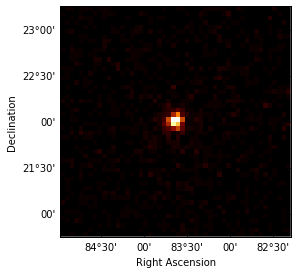

Energy range: 0.50 TeV to 1.20 TeV


In [9]:
# show counts image with idx = 0
idx = 0
counts.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

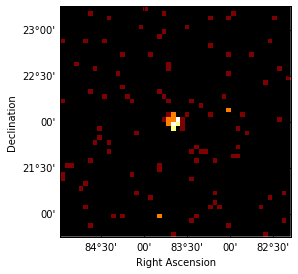

Energy range: 6.93 TeV to 16.65 TeV


In [10]:
idx = 3
counts.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

In [11]:
counts.write('counts_cube.fits.gz', overwrite=True)

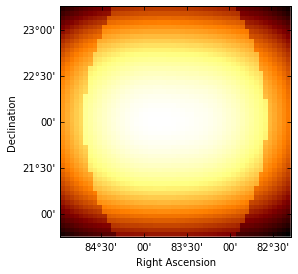

Energy range: 0.50 TeV to 1.20 TeV


In [12]:
background = cube_maker.bkg_cube

idx = 0
background.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

In [13]:
background.write('background_cube.fits.gz', overwrite=True)

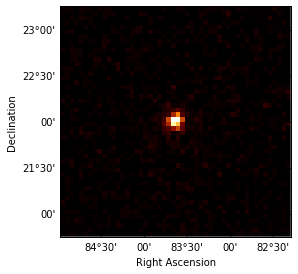

Energy range: 0.50 TeV to 1.20 TeV


In [14]:
excess = cube_maker.excess_cube

idx = 0
excess.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

In [15]:
excess.write('excess_cube.fits.gz', overwrite=True)

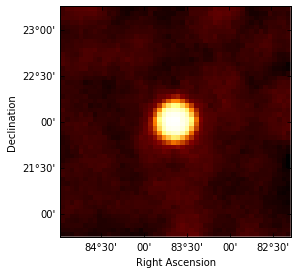

Energy range: 0.50 TeV to 1.20 TeV


In [16]:
significance = cube_maker.significance_cube

idx = 0
significance.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

In [17]:
significance.write('significance_cube.fits.gz', overwrite=True)

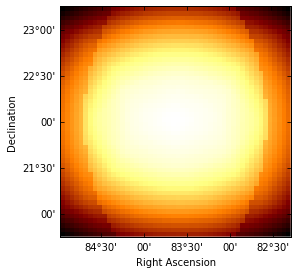

Energy range: 0.50 TeV to 1.20 TeV


In [18]:
exposure = cube_maker.exposure_cube

idx = 0
exposure.sky_image_idx(idx=idx).show()
print('Energy range: {emin:.2f} to {emax:.2f}'.format(emin=energies[idx], emax=energies[idx + 1]))

In [19]:
exposure.write('exposure_cube.fits.gz', overwrite=True)

### Compute mean psf from a list of observations

Make the mean PSF and write it

In [20]:
mean_psf_cube = cube_maker.make_mean_psf_cube(REF_CUBE)

/home/hfm/adonath/Software/Repositories/gammapy/gammapy/image/models/gauss.py:254: RuntimeWarning: invalid value encountered in true_divide
  self.norms /= self.integral
/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/home/hfm/adonath/Software/Applications/anaconda3.5/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


PSF image in the energy band: 6.93-16.65 TeV


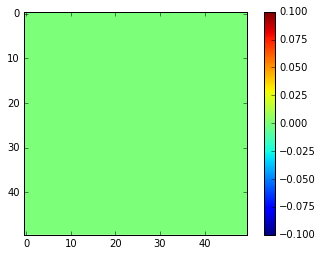

In [21]:
energies=mean_psf_cube.energies(mode="edges")
print("PSF image in the energy band: "+str("%.2f"%energies[3].value)+"-"+str("%.2f"%energies[4].value)+" TeV")
plt.figure()
plt.imshow(mean_psf_cube.data[3,:,:],interpolation='None')
plt.colorbar()

## Make the cube analysis assuming a true energy different than the reconstructed energy

In [22]:
cube_maker = StackedObsCubeMaker(empty_cube_images=REF_CUBE,
                                 empty_exposure_cube=REF_CUBE_TRUE,
                                 offset_band=offset_band,
                                 data_store=data_store,
                                 obs_table=data_store.obs_table,
                                 exclusion_mask=exclusion_mask,
                                 save_bkg_scale=True)
cube_maker.make_cubes(make_background_image=True, radius=10.)

obslist = [data_store.obs(id) for id in data_store.obs_table["OBS_ID"]]
ObsList = ObservationList(obslist)

#The PSF cube is now calculated in true energie
mean_psf_cube = make_mean_psf_cube(image_size=50, energy_cube=etrue, center_maps=center, center=center,
                                   ObsList=ObsList,
                                   spectral_index=2.3)


filename_mask = 'exclusion_mask.fits'
filename_counts = 'counts_cube.fits'
filename_bkg = 'bkg_cube.fits'
filename_significance = 'significance_cube.fits'
filename_excess = 'excess_cube.fits'
filename_exposure = 'exposure_cube_etrue.fits'
filename_psf = 'psf_cube_etrue.fits'

exclusion_mask.write(filename_mask, clobber=True)
cube_maker.counts_cube.write(filename_counts, format="fermi-counts", clobber=True)
cube_maker.bkg_cube.write(filename_bkg, format="fermi-counts", clobber=True)
cube_maker.significance_cube.write(filename_significance, format="fermi-counts", clobber=True)
cube_maker.excess_cube.write(filename_excess, format="fermi-counts", clobber=True)
cube_maker.exposure_cube.write(filename_exposure, format="fermi-counts", clobber=True)
mean_psf_cube.write(filename_psf, format="fermi-counts", clobber=True)



NameError: name 'make_mean_psf_cube' is not defined

In [ ]:
counts_energies=cube_maker.counts_cube.energies(mode="edges")
print("the bin edges of the count cubes ", counts_energies)
print("")
true_energies=cube_maker.exposure_cube.energies(mode="edges")
print("the bin edges of the exposure cubes ", true_energies)
print("")

### Compute mean RMF for a list of observations

In [ ]:
# get reference energies
e_true = REF_CUBE_TRUE.energies('edges')
e_reco = REF_CUBE.energies('edges')

mean_rmf = obs_list.make_mean_edisp(position=position, e_true=e_true, e_reco=e_reco)

In [ ]:
mean_rmf.plot_matrix()

In [ ]:
# write to file
mean_rmf.write('rmf.fits.gz', overwrite=True)

## Exercises
- Take another dataset
- Change the Cube binning

Now that we created some cubes for counts, background, exposure, psf from a set of runs we will learn in the future tutorials how to use it for a 3D analysis (morphological and spectral)